# Protein Level Analysis

In [1]:
library(readxl)
library(sets)
library(tidyverse)
library(limma)
library(gplots)
library(ggplot2)
library(dplyr)
library(ROSE)
library(scutr)
library(openxlsx)

# set working directory
#setwd('/lustre/home/reynaj/Projects/20241011.kevin_byrd.ibd_nulisa')
setwd('/home/reynaj/projects/kevin_byrd/20241011.kevin_byrd.ibd_nulisa')

# set the output directory
outdir <- "results/specimen_focused/limma/uc_only/"

# Check if the directory exists, and create it if it doesn't
if (!dir.exists(outdir)) {
  dir.create(outdir)
}

# set global values
da_levels <- c('N/A (Non-IBD Control)', 'Quiescent', 'Mild', 'Moderate')
highlight_genes <- list(list(name = "IL36B", color = "green"))
save_flag <- TRUE

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ forcats::%>%()           masks stringr::%>%(), dplyr::%>%(), purrr::%>%(), tidyr::%>%(), tibble::%>%(), sets::%>%()
✖ lubridate::as.interval() masks sets::as.interval()
✖ dplyr::filter()          masks stats::filter()
✖ lubridate::interval()    masks sets::interval()
✖ lubridate::is.interval() masks sets::is.interval()
✖ dplyr::lag()             masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to for

## Load the datasets

In [2]:
# load protein data
fn = "results/specimen_focused/comp_data/protein_levels.npq.tsv"
protein_data <- read.table(fn, header=TRUE, check.names=FALSE, sep = "\t")

# load clinical data
fn = "results/specimen_focused/comp_data/clinical_data.tsv"
clinical_data <- read.table(fn, header=TRUE, sep="\t")

# remove alamar samples completely
clinical_data <- clinical_data[clinical_data$ibd_diagnosis != "Alamar_Sample_Control",] 
protein_data <- protein_data[, clinical_data$sample_id]

# extract just CD and UC data
focus_idxs <- which(clinical_data$ibd_diagnosis %in% c("UC"))
clinical_data = clinical_data[focus_idxs,]
protein_data = protein_data[,focus_idxs]

In [3]:
create_volcano_plot_v2 <- function(results, topn=10, filename='', save=FALSE) {
    
  # Create a logical column for significance
  results$significant <- results$P.Value <= 0.05
  
  # Identify the top 10 genes based on P.Value
  top_genes <- results %>%
    arrange(P.Value) %>%
    slice_head(n = topn)
  
  # Create a new column for color based on logFC
  results$color <- ifelse(results$significant & results$logFC < 0, "blue", 
                          ifelse(results$significant & results$logFC > 0, "red", "grey"))

  # Create a new column for shape based on significance
  results$shape <- as.factor(ifelse(results$adj.P.Val < 0.05, 24, 21))  # 18 for diamonds, 16 for circles
  
  # Create the volcano plot
  p <- ggplot(results, aes(x = logFC, y = -log10(P.Value), color = color)) +
    scale_color_identity() +  # Use the colors defined in the data
    theme_minimal() +
    labs(title = "", x = "Log2 Fold Change (logFC)", y = "-Log10 P-value") +
    theme(legend.position = "none",
          panel.background = element_rect(fill = "white", color = NA),
          plot.background = element_rect(fill = "white", color = NA)) +  # Hide legend if not needed
    geom_text(data = top_genes, aes(label = rownames(top_genes)), 
              vjust = -0.5, hjust = 0.5, size = 3, color = "black") +  # Annotate top 10 genes
    geom_point(aes(x = logFC, y = -log10(P.Value)), 
               fill = results$color,
               color = results$color,
               shape=results$shape,
               size=2)
  
    if (save == TRUE){
        ggsave(filename, plot = p, width = 8, height = 6)
    }
    return(p)
}

color_excel_pvalues <- function(wb, data, sheet="Sheet1", stat_colname="t", pvalue_colname="adj.P.Val", pvalue_colnum=6){

    # Define styles for different significance levels
    style_red <- createStyle(fgFill = "#FFB09C")  # Red for high significance but positive tstat
    style_blue <- createStyle(fgFill = "#ADD8E6")  # Blue for high significance but negative tstat

    # Apply styles based on significance
    for (i in 1:nrow(data)) {
        
        pval = data[i, pvalue_colname]
        if (pval < 0.05) {
            if (data[i, stat_colname] >= 0){
                addStyle(wb, sheet = sheet, style = style_red, rows = i + 1, cols = pvalue_colnum, gridExpand = TRUE)
            } else {
                addStyle(wb, sheet = sheet, style = style_blue, rows = i + 1, cols = pvalue_colnum, gridExpand = TRUE)
            }
        }
    }
}

### Run limma with the disease activity indicator

In [4]:
# make programmer friendly
dict <- c("Active Disease" = "active", "In-active Disease" = "inactive")
clinical_data <- clinical_data %>%
  mutate(disease_activity_indicator = recode(disease_activity_indicator, !!!dict))

In [5]:
# set groups and design
#group <- factor(clinical_data$crp_severity, levels=c("Normal", "Mild", "Moderate", "High")) # no normal of course
group <- factor(clinical_data$disease_activity_indicator, levels=c("active", "inactive"))
design <- model.matrix(~ 0 + group)
colnames(design) <- levels(group)

# set the contrasts
contrast.matrix <- makeContrasts(
  act_inact = active - inactive,
  levels = design
)

# fit the models
fit <- lmFit(protein_data, design)
fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

In [6]:
# get results
results_act_vs_inact <- topTable(fit2, adjust="BH", coef="act_inact", number=Inf)

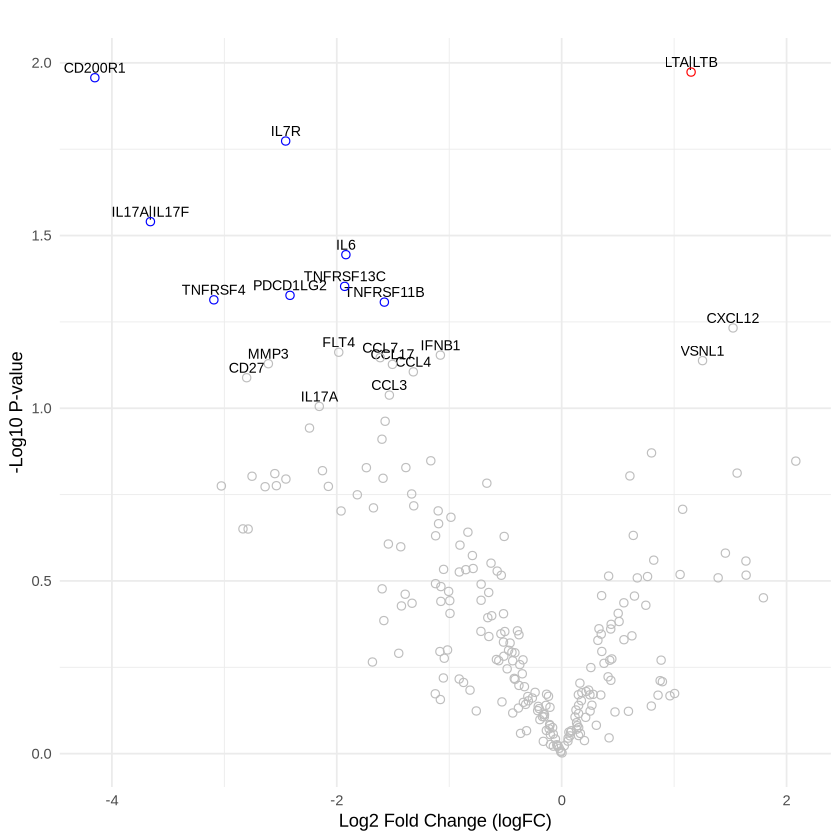

In [7]:
fn1 = file.path(outdir, "limma.population_uc_only.disease_activity_indicator.active_versus_inactive.png")
p1 <- create_volcano_plot_v2(results_act_vs_inact, topn=20, filename=fn1, save=save_flag); p1

In [8]:
wb <- createWorkbook()

# # add quiescent_versus_mild
addWorksheet(wb, "active_versus_inactive")
writeData(wb, sheet = "active_versus_inactive", x = results_act_vs_inact, rowNames = TRUE)
insertImage(wb, sheet = "active_versus_inactive", file = fn1, startRow = 4, startCol = 9, width = 8, height = 6)
color_excel_pvalues(wb, results_act_vs_inact, sheet = "active_versus_inactive", pvalue_colname="P.Value", pvalue_colnum=5)

# save the workbook
excel_fn = file.path(outdir, 'limma.population_cd.ibd_subtypes.disease_activity_indicator.xlsx')
saveWorkbook(wb, file = excel_fn, overwrite = TRUE)

### Plot top DEG genes

In [9]:
# extract top protein data
top_deg_results <- results_act_vs_inact[0:20,]
top_deg_list <- rownames(top_deg_results)

# extract protein data
top_deg_protein_data <- t(protein_data)
top_deg_protein_data <- as.data.frame(top_deg_protein_data[, top_deg_list])

# combine with clinical data
top_deg_protein_data <- cbind(top_deg_protein_data, clinical_data)
top_deg_protein_data <- top_deg_protein_data %>% rownames_to_column(var = "Sample")
top_deg_protein_data = top_deg_protein_data %>% pivot_longer(cols = -c(Sample, colnames(clinical_data)),
                                                             names_to = "Gene",
                                                             values_to = "Expression")
# Uppercase the active versus inactive labels
replace_dict = list(active="Active", inactive="Inactive")
top_deg_protein_data <- top_deg_protein_data %>% mutate(disease_activity_indicator_main = recode(disease_activity_indicator, !!!replace_dict))

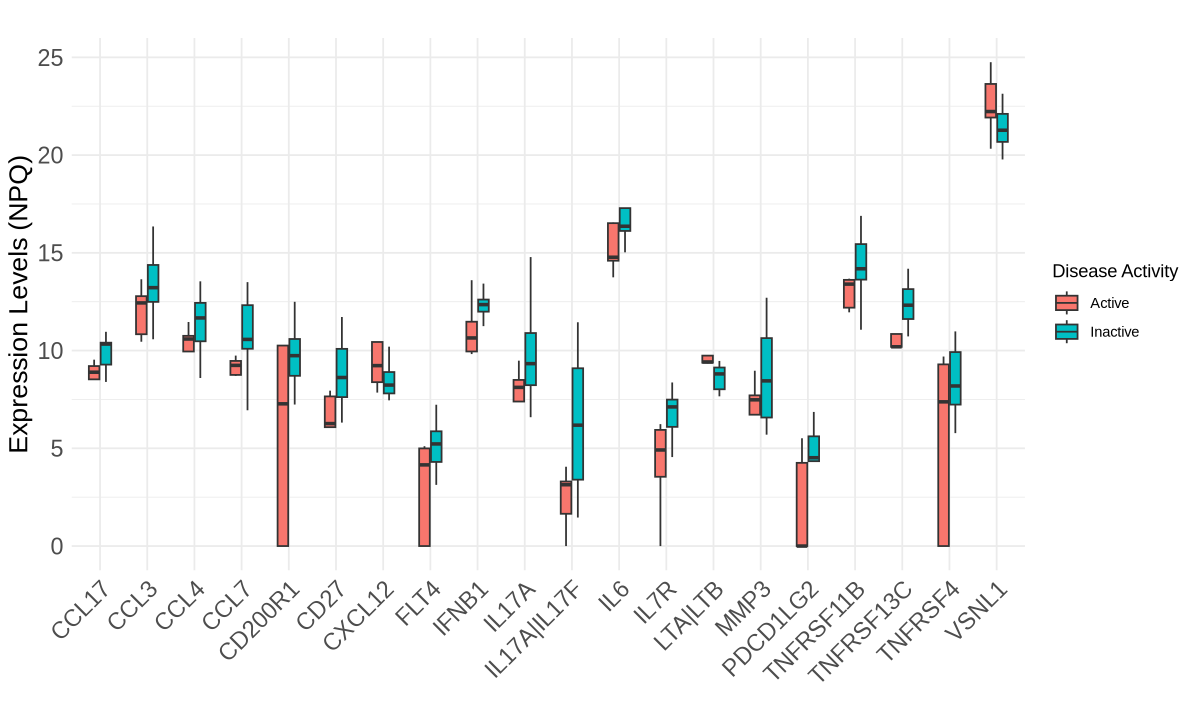

In [10]:
p <- ggplot(top_deg_protein_data, aes(x=Gene, y=Expression)) +
            labs(title = "", x = "", y = "Expression Levels (NPQ)", fill="Disease Activity") +
            geom_boxplot(aes(fill=disease_activity_indicator_main), width=0.5, outlier.shape = NA) + 
            theme_minimal() + 
            theme(axis.text.x = element_text(angle=45, hjust=1, size=14),
                  axis.text.y = element_text(size=14),
                  axis.title.y = element_text(size=16))
options(repr.plot.width = 10, repr.plot.height = 6)
print(p)

fn2 = file.path(outdir, "limma.population_uc_only.disease_activity_indicator.active_versus_inactive.top_gene_levels.png")                  
ggsave(fn2, dpi=600, plot = p, width = 10, height = 6)

In [11]:
fn2

[1] "results/specimen_focused/limma/uc_only//limma.population_uc_only.disease_activity_indicator.active_versus_inactive.top_gene_levels.png"

### Run limma with CRP Severity Scores

In [12]:
# extract just CD and UC data that contains valid (non-N/A) CRP values 
valid_idxs <- which(clinical_data$crp_severity != "N/A")
curr_clinical_data = clinical_data[valid_idxs,]
curr_protein_data = protein_data[,valid_idxs]

# set groups and design
group <- factor(curr_clinical_data$crp_severity, levels=c("Mild", "Moderate", "High"))
design <- model.matrix(~ 0 + group)
colnames(design) <- levels(group)

# set the contrasts
contrast.matrix <- makeContrasts(
  mild_vs_mod = Mild - Moderate,
  mild_vs_high = Mild - High,
  mod_vs_high = Moderate - High,
  levels = design
)

# fit the models
fit <- lmFit(curr_protein_data, design)
fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

# get results
results_mild_vs_mod <- topTable(fit2, adjust="BH", coef="mild_vs_mod", number=Inf)
results_mild_vs_high <- topTable(fit2, adjust="BH", coef="mild_vs_high", number=Inf)
results_mod_vs_high <- topTable(fit2, adjust="BH", coef="mod_vs_high", number=Inf)

Coefficients not estimable: High 


Warning message:
“Partial NA coefficients for 230 probe(s)”


ERROR: Error in contrasts.fit(fit, contrast.matrix): trying to take contrast of non-estimable coefficient


In [ ]:
fn1 = file.path(outdir, "limma.population_uc_uc.crp_severity.mild_vs_mod.png")
p1 <- create_volcano_plot_v2(results_mild_vs_mod, topn=20, filename=fn1, save=save_flag); p1

In [ ]:
fn2 = file.path(outdir, "limma.population_uc_uc.crp_severity.mild_vs_high.png")
p2 <- create_volcano_plot_v2(results_mild_vs_high, topn=20, filename=fn2, save=save_flag); p2

In [ ]:
fn3 = file.path(outdir, "limma.population_uc_uc.crp_severity.mod_vs_high.png")
p3 <- create_volcano_plot_v2(results_mod_vs_high, topn=20, filename=fn3, save=save_flag); p3

In [ ]:
wb <- createWorkbook()

# # add mild_vs_mod
addWorksheet(wb, "mild_vs_mod")
writeData(wb, sheet = "mild_vs_mod", x = results_mild_vs_mod, rowNames = TRUE)
insertImage(wb, sheet = "mild_vs_mod", file = fn1, startRow = 4, startCol = 9, width = 8, height = 6)
color_excel_pvalues(wb, results_mild_vs_mod, sheet = "mild_vs_mod", pvalue_colname="P.Value", pvalue_colnum=5)
color_excel_pvalues(wb, results_mild_vs_mod, sheet = "mild_vs_mod", pvalue_colname="adj.P.Val", pvalue_colnum=6)

# add mild_vs_high
addWorksheet(wb, "mild_vs_high")
writeData(wb, sheet = "mild_vs_high", x = results_mild_vs_high, rowNames = TRUE)
insertImage(wb, sheet = "mild_vs_high", file = fn2, startRow = 4, startCol = 9, width = 8, height = 6)
color_excel_pvalues(wb, results_mild_vs_high, sheet = "mild_vs_high", pvalue_colname="P.Value", pvalue_colnum=5)
color_excel_pvalues(wb, results_mild_vs_high, sheet = "mild_vs_high", pvalue_colname="adj.P.Val", pvalue_colnum=6)

# add mod_vs_high
addWorksheet(wb, "mod_vs_high")
writeData(wb, sheet = "mod_vs_high", x = results_mod_vs_high, rowNames = TRUE)
insertImage(wb, sheet = "mod_vs_high", file = fn3, startRow = 4, startCol = 9, width = 8, height = 6)
color_excel_pvalues(wb, results_mod_vs_high, sheet = "mod_vs_high", pvalue_colname="P.Value", pvalue_colnum=5)
color_excel_pvalues(wb, results_mod_vs_high, sheet = "mod_vs_high", pvalue_colname="adj.P.Val", pvalue_colnum=6)

# save the workbook
excel_fn = file.path(outdir, 'limma.all_data.ibd_subtypes.crp_severity_scores.xlsx')
saveWorkbook(wb, file = excel_fn, overwrite = TRUE)